# setup

In [1]:
import os

if os.getcwd().split('/')[-1] == 'notebooks':
    os.chdir('..')

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt

from mnist1d.data import make_dataset, get_dataset_args
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# init

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 100
NUM_WORKERS = 6
EPOCHS = 200

# mnist1d

In [4]:
default_args = get_dataset_args()
data = make_dataset(default_args)
x, y, t = data['x'], data['y'], data['t']
x.shape, y.shape, t.shape

((4000, 40), (4000,), (40,))

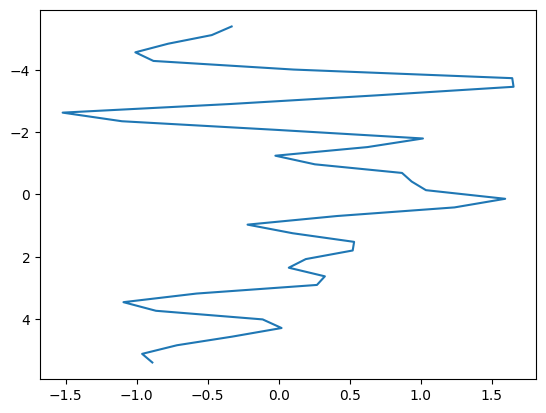

In [5]:
plt.plot(x[0, :], t);
plt.gca().invert_yaxis();

## split

In [6]:
x_trn, x_val, y_trn, y_val = train_test_split(x, y, test_size = 0.1)
x_tst, y_tst = data['x_test'], data['y_test']
(x_trn.shape, y_trn.shape), (x_val.shape, y_val.shape), (x_tst.shape, y_tst.shape)

(((3600, 40), (3600,)), ((400, 40), (400,)), ((1000, 40), (1000,)))

## loader

In [7]:
class MNIST1D(Dataset):
    def __init__(self, db, device = 'cpu'):
        self.db = db
        self.db['x'] = torch.Tensor(self.db['x']).to(device)
        self.db['y'] = torch.LongTensor(self.db['y']).to(device)

    def __len__(self):
        return self.db['x'].shape[0]
    
    def __getitem__(self, idx):
        return {'x': self.db['x'][idx, :], 'y': self.db['y'][idx]}

# model

In [8]:
class MLP(nn.Module):
    def __init__(self, depth, xs = 40, ys = 10, hs = 100):
        super(MLP, self).__init__()
        self.depth = depth

        self.first = nn.Linear(xs, hs)
        self.linears = nn.ModuleList([nn.Linear(hs, hs) for u in range(self.depth)])
        self.last = nn.Linear(hs, ys)
    
    def forward(self, x):
        h = self.first(x).relu()
        for u in range(self.depth):
            h = h + self.linears[u](h).relu()
        return self.last(h)

In [9]:
class CNN(nn.Module):
    def __init__(self, depth, xs = 1, ys = 10, hs = 25):
        super(CNN, self).__init__()
        self.depth = depth
        linear_in = hs * 40
        self.first = nn.Conv1d(in_channels = xs, out_channels = hs, kernel_size = 3, padding = 'same')

        self.convs = nn.ModuleList([nn.Conv1d(in_channels = hs, out_channels = hs, kernel_size = 3, padding = 'same') for u in range(self.depth)])

        # self.last = nn.Conv1d(in_channels = hs, out_channels = hs, kernel_size = 3, padding = 'same')
        self.linear = nn.Linear(linear_in, ys)

    def forward(self, x, verbose=False):
        x = x.view(-1, 1, x.shape[-1])
        h = self.first(x).relu()
        for u in range(self.depth):
            h = self.convs[u](h).relu()
        
        # h = self.last(h).relu()
        h = h.view(h.shape[0], -1)
        return self.linear(h)

# baseline

In [10]:
def trn_loop(model, loader, optimizer, criterion):
    model.train()
    
    log = 0
    for batch in (loader):
        # x, y = [u.to(device) for u in batch.values()]
        x, y = [u for u in batch.values()]
        
        yhat = model.forward(x)
        loss = criterion(yhat, y)

        # optimizer.zero_grad()
        # loss.backward()
        # optimizer.step()
        loss.backward(); optimizer.step(); optimizer.zero_grad()
        
        log += loss.item()
    log /= loader.dataset.__len__()
    return log

In [11]:
def val_loop(model, loader, criterion):
    model.eval()

    log = 0
    with torch.no_grad():
        for batch in (loader):
            # x, y = [u.to(device) for u in batch.values()]
            x, y = [u for u in batch.values()]
            
            yhat = model.forward(x)
            loss = criterion(yhat, y)
            
            log += loss.item()
    log /= loader.dataset.__len__()
    return log

In [12]:
def tst_loop(model, loader, criterion):
    model.eval()

    log = 0
    acc = 0
    with torch.no_grad():
        for batch in (loader):
            # x, y = [u.to(device) for u in batch.values()]
            x, y = [u for u in batch.values()]
            
            yhat = model.forward(x)
            loss = criterion(yhat, y)

            log += loss.item()
            acc += np.sum(yhat.argmax(-1).cpu().numpy() == y.cpu().numpy())
    log /= loader.dataset.__len__()
    acc /= loader.dataset.__len__()
    return log, acc

In [13]:
# ds_trn = MNIST1D(db = {'x': x_trn, 'y': y_trn})
# ds_val = MNIST1D(db = {'x': x_val, 'y': y_val})
# ds_tst = MNIST1D(db = {'x': x_tst, 'y': y_tst})
ds_trn = MNIST1D(db = {'x': x_trn, 'y': y_trn}, device = device)
ds_val = MNIST1D(db = {'x': x_val, 'y': y_val}, device = device)
ds_tst = MNIST1D(db = {'x': x_tst, 'y': y_tst}, device = device)

# trn_loader = DataLoader(ds_trn, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, shuffle = True)
# val_loader = DataLoader(ds_val, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, shuffle = False)
# tst_loader = DataLoader(ds_tst, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, shuffle = False)
trn_loader = DataLoader(ds_trn, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(ds_val, batch_size = BATCH_SIZE, shuffle = False)
tst_loader = DataLoader(ds_tst, batch_size = BATCH_SIZE, shuffle = False)

In [14]:
def baseline(depth, loaders, lr, device = 'cuda'):
    trn_loader, val_loader, tst_loader = loaders

    # model = MLP(depth = depth)
    model = CNN(depth = depth)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = lr)

    trn_log = []
    val_log = []
    # minimo = 1e3
    tst_log = []
    acc_log = []
    accv_log = []
    for epoch in tqdm(range(EPOCHS)):
        trn_log.append(trn_loop(model, trn_loader, optimizer, criterion))
        # val_log.append(val_loop(model, val_loader, criterion))
    #     if val_log[-1] < minimo:
    #         minimo = val_log[-1]
    #         torch.save(model.state_dict(), 'output/partial.pt')
        log, acc = tst_loop(model, val_loader, criterion)
        val_log.append(log)
        accv_log.append(acc)
        log, acc = tst_loop(model, tst_loader, criterion)
        tst_log.append(log)
        acc_log.append(acc)
    # model.load_state_dict(torch.load('output/partial.pt'))
    
    fig, axes = plt.subplots(1, 2, figsize = (14, 4))
    axes[0].plot(trn_log);
    axes[0].plot(val_log);
    axes[0].plot(tst_log);
    
    axes[1].plot(accv_log);
    axes[1].plot(acc_log);

    minimo = np.min(val_log)
    best = np.argmin(val_log)
    axes[0].axhline(y = minimo, color = 'black', linestyle = 'dashed');
    print(minimo, best, tst_log[best])
    
    maximo = np.max(accv_log)
    best = np.argmax(accv_log)
    axes[1].axhline(y = maximo, color = 'black', linestyle = 'dashed');
    print(maximo, best, acc_log[best], acc_log[-1])

    # print(tst_loop(model, tst_loader, criterion))

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:12<00:00, 15.96it/s]


0.0057082495838403705 21 0.005570977509021759
0.8075 118 0.827 0.819


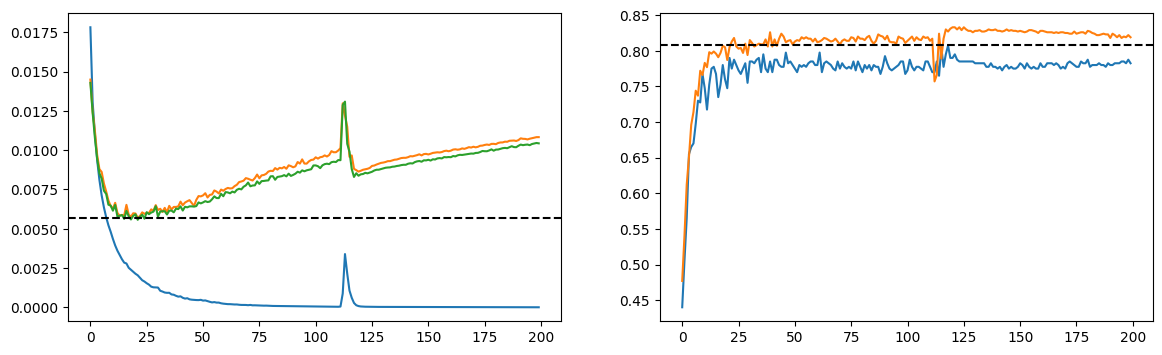

In [15]:
baseline(depth = 0, loaders = [trn_loader, val_loader, tst_loader], lr = 1e-2, device = device)

100%|██████████| 200/200 [00:15<00:00, 13.10it/s]


0.00268140509724617 14 0.0036584277004003524
0.91 10 0.887 0.902


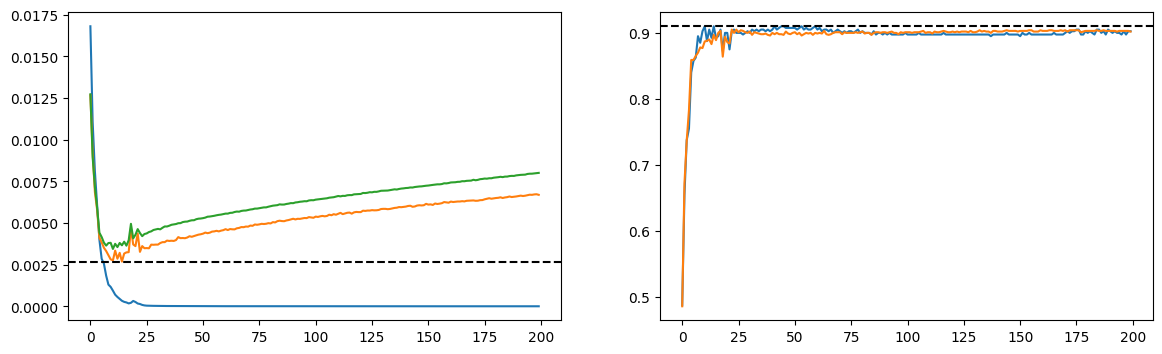

In [16]:
baseline(depth = 1, loaders = [trn_loader, val_loader, tst_loader], lr = 1e-2, device = device)

100%|██████████| 200/200 [00:17<00:00, 11.33it/s]


0.0027743948251008985 24 0.002773545295000076
0.9375 24 0.929 0.93


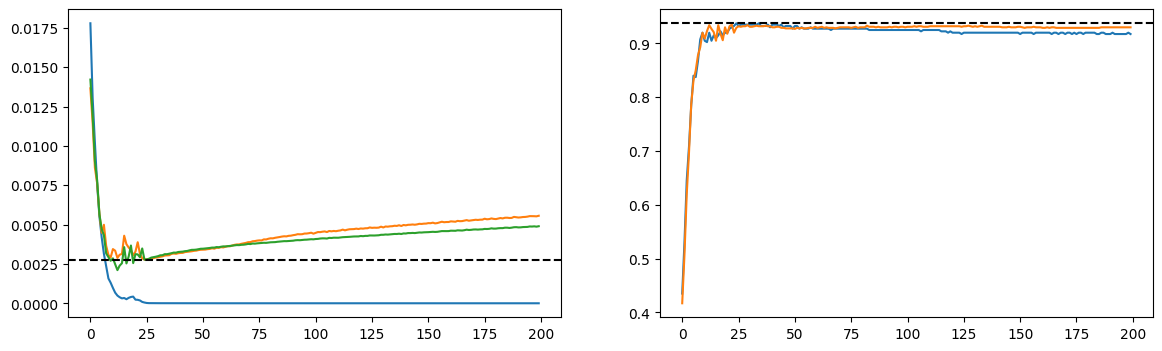

In [17]:
baseline(depth = 2, loaders = [trn_loader, val_loader, tst_loader], lr = 1e-2, device = device)

100%|██████████| 200/200 [00:20<00:00,  9.79it/s]


0.002081389408558607 10 0.0018857181295752526
0.96 10 0.94 0.954


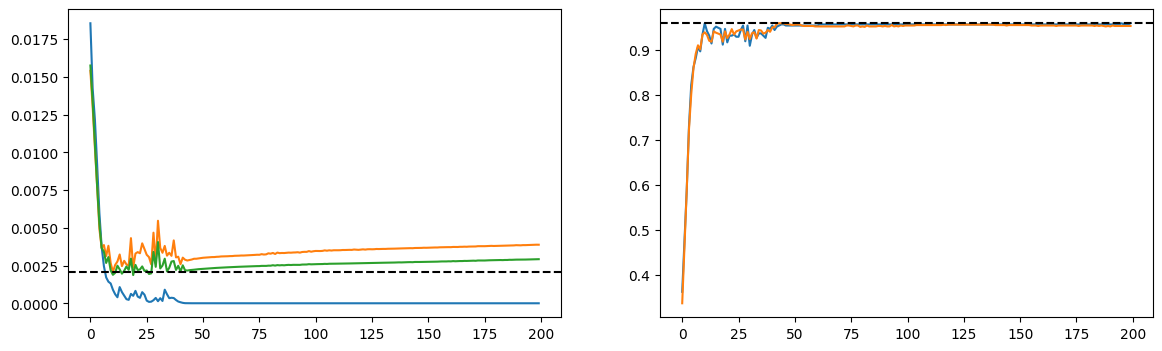

In [18]:
baseline(depth = 3, loaders = [trn_loader, val_loader, tst_loader], lr = 1e-2, device = device)

100%|██████████| 200/200 [00:22<00:00,  8.79it/s]


0.0014833212457597256 41 0.0021691340655088424
0.9725 93 0.969 0.975


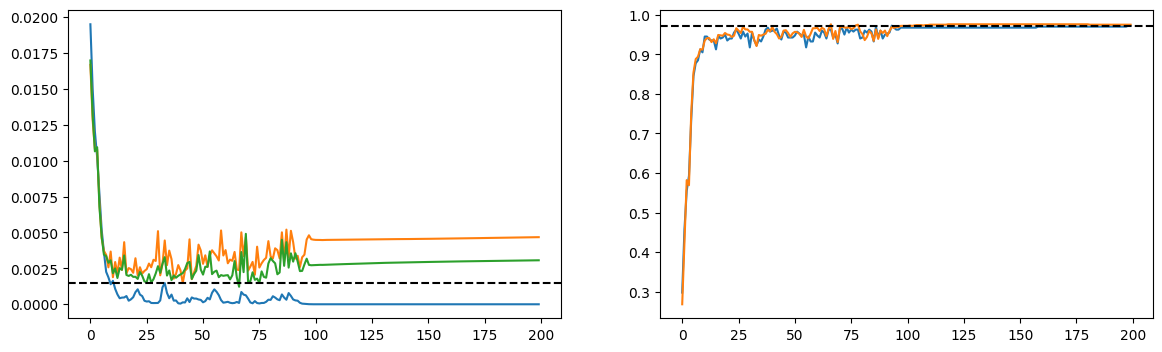

In [19]:
baseline(depth = 4, loaders = [trn_loader, val_loader, tst_loader], lr = 1e-2, device = device)

100%|██████████| 200/200 [00:25<00:00,  7.94it/s]


0.0010595074016600846 74 0.0017427871413528918
0.98 48 0.962 0.969


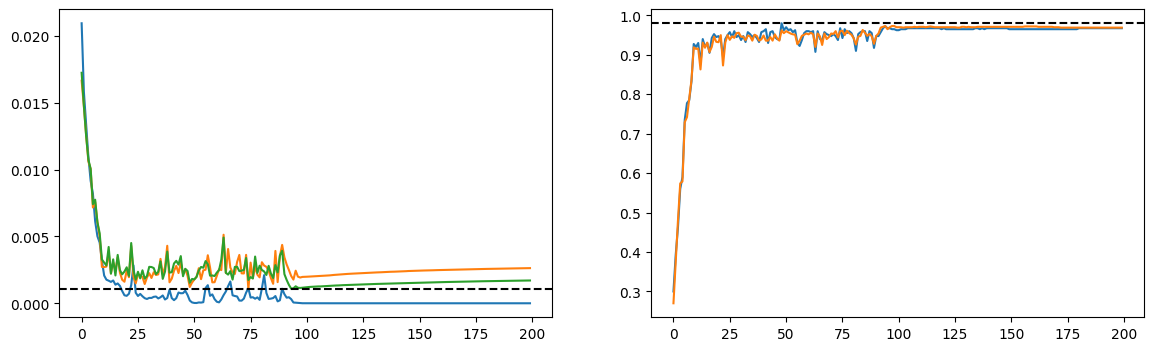

In [20]:
baseline(depth = 5, loaders = [trn_loader, val_loader, tst_loader], lr = 1e-2, device = device)

100%|██████████| 200/200 [00:27<00:00,  7.28it/s]


0.002267153924331069 88 0.0016859384551644325
0.965 44 0.955 0.971


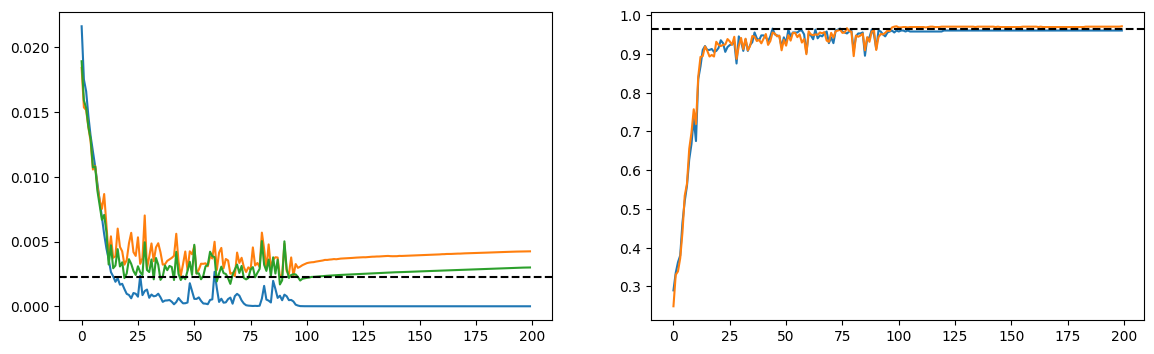

In [21]:
baseline(depth = 6, loaders = [trn_loader, val_loader, tst_loader], lr = 1e-2, device = device)

100%|██████████| 200/200 [00:30<00:00,  6.64it/s]


0.0011236902698874473 21 0.0012611533142626286
0.9775 99 0.963 0.966


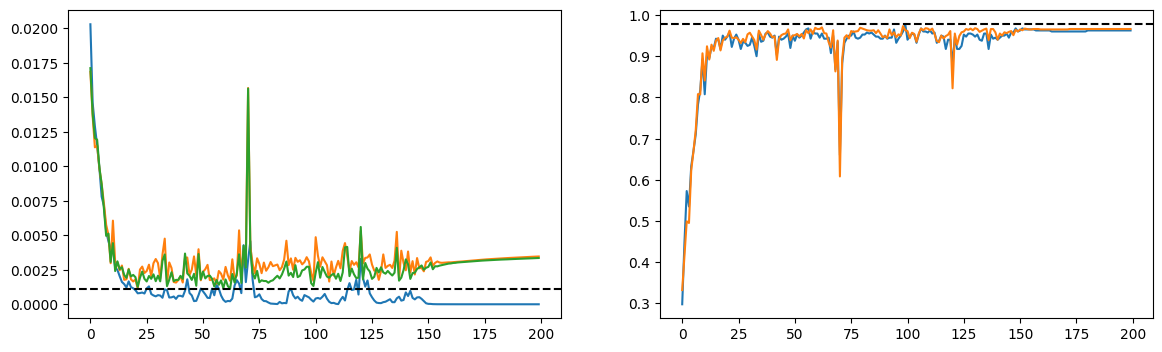

In [22]:
baseline(depth = 7, loaders = [trn_loader, val_loader, tst_loader], lr = 1e-2, device = device)